# TD-lambda

What is a good n value for n-step TD? How using a weighted combination of all n-step targets?

The hyperparameter alpha.

In [1]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

We write the prediction function that works for TD-lambda:

In [2]:
def td_lambda(pi, env, gamma=1.0,
              init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
              lambda_=0.2, n_episodes=500):
    nS = env.observation_space.n
    
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # initialize the eligibility trace vector
    E = np.zeros(nS, dtype=np.float64)
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # loop for every episode
    for e in range(n_episodes):
        
        # set E to zero every new episode
        E.fill(0)
        
        # get the initial state
        state, done = env.reset(), False
        
        # get into the time step loop
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # interact with the environment for one step and get the experience tuple
            next_state, reward, done, _ = env.step(action)
            
            # use that experience to calculate the TD error as usual
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            
            # increment the eligibility of state by 1
            E[state] = E[state] + 1
            
            # apply the error update to all eligible states as indicated by E
            V = V + alphas[e] * td_error * E
            
            # decay E
            E = gamma * lambda_ * E
            
            state = next_state
            
        V_track[e] = V
    return V, V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [3]:
class Space:
    def __init__(self, value):
        self.n = value 
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(7)
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        self._state += np.random.choice([-1, 1])
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [4]:
env = RandomWalk()

We evaluate an "all-left" policy

In [5]:
def pi(state):
    return 1

We use the n-step Temporal-Difference prediction algorithm and show the estimates over episodes

In [10]:
V_td_lambda, V_td_lambda_track = td_lambda(pi, env, lambda_=0.3, n_episodes=500)

In [11]:
print(V_td_lambda)

[0.         0.17625573 0.34779507 0.51176955 0.66356833 0.82794129
 0.        ]


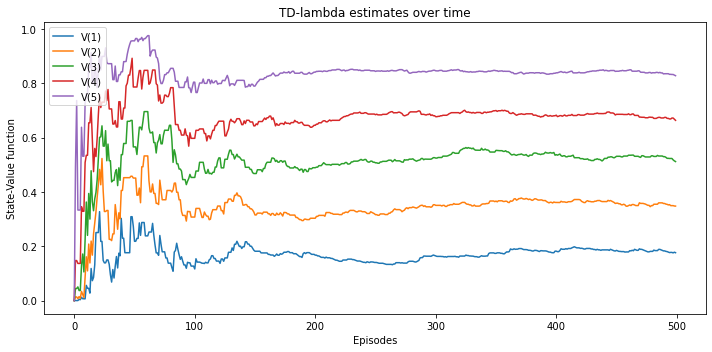

In [12]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.figure(figsize=(10,5))
plt.plot(V_td_lambda_track[:,1:6])
plt.title('TD-lambda estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()